In [1]:
import numpy as np # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
#import r
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE # sampling technique
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score

In [6]:
#plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

### Moved to Google Colab to Run Sentiment Score

In [2]:
# load in review data and check 
start_time = time.time()
yp_review = pd.read_json("review.json", lines=True)
print("yp_review --- %s seconds ---" % (time.time() - start_time)) #195 seconds

yp_review --- 175.2106692790985 seconds ---


In [3]:
print(yp_review.shape) #(6,685,900, 9)) reviewes
yp_review.head(2)

(6685900, 9)


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg


In [4]:
feature=yp_review.columns
feature[8]

'user_id'

In [5]:
for i in range(9):
    print("unique value for", feature[i])
    print(yp_review[feature[i]].value_counts().index) # 0 means not food place
    print(yp_review[feature[i]].value_counts().values) 

unique value for business_id
Index(['4JNXUYY8wbaaDmk3BPzlWw', 'RESDUcs7fIiihp38-d6_6g',
       'K7lWdNUhCbcnEvI0NhGewg', 'f4x1YBxkLrZg652xt2KR5g',
       'cYwJA2A6I12KNkm2rtXd5g', 'DkYS3arLOhA8si5uUEmHOw',
       '2weQS-RnoOBhb1KsHKyoSQ', '5LNZ67Yw9RD6nf4_UhXOjw',
       'iCQpiavjjPzJ5_3gPD5Ebg', 'SMPbvZLSMMb7KU76YNYMGg',
       ...
       'xiRSfyTokUa3mGZwJ3o8DA', 'AoiXniKuwY9ohMyIVLkhHA',
       'Bc1C4RKc-1ALDxoGaOaoiQ', '4fHoazTRh6H53GLoJUUqbQ',
       'fiUpPtW1a7saRB-FaFZE0Q', 'VAikmq9dBuKjucPXip6nfg',
       'D6iF0IPs72Uis8U3jB6HUQ', 'o54U0Q6flE0aoqCEjugGMg',
       '6XrZ-AZRN53CSDZGWO6WKg', 'VnpZg4h3O5AlcMjJYErowA'],
      dtype='object', length=192606)
[8570 8568 6887 ...    3    3    2]
unique value for cool
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            169, 171, 173, 177, 178, 179, 182, 183, 184,  -1],
           dtype='int64', length=201)
[5013287 1013484  313433  129433   65993   38944   25562   17571   12528
    9426    7142    55

[20 16 12 ...  1  1  1]
unique value for useful
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            251, 249, 162, 136, 241, 239, 235, 232, 229,  -1],
           dtype='int64', length=289)
[3570453 1430632  669040  349808  201772  125187   82613   56609   41111
   30155   22771   16966   13626   10925    8785    7167    5973    4768
    4020    3552    3006    2525    2219    2025    1743    1590    1309
    1158    1118     937     903     814     714     668     579     560
     471     427     414     399     348     293     282     278     268
     243     239     230     194     175     175     163     144     138
     137     129     116     113     110     108     106     102      98
      88      87      75      75      70      66      64      63      62
      55      53      53      49      43      40      40      40      40
      37      35      34      33      32      31      30      29      28
      26      24      24      22      22   

In [6]:
# check null value
yp_review.isnull().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

In [4]:
## Kaggle Dataset:
from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"));

Dataset_Challenge_Dataset_Agreement.pdf
yelp_business.csv
yelp_business_attributes.csv
yelp_business_hours.csv
yelp_checkin.csv
yelp_review.csv
yelp_tip.csv
yelp_user.csv



In [9]:
import pickle
# pickle yp_review
filename = 'yp_review'
outfile = open(filename,'wb')
pickle.dump(yp_review,outfile)
outfile.close()

In [16]:
#start_time = time.time()
##yelp_business = pd.read_csv('./input/yelp_business.csv')
##yelp_business_attributes = pd.read_csv('./input/yelp_business_attributes.csv')
##yelp_business_hours = pd.read_csv('./input/yelp_business_hours.csv')
##yelp_checkin = pd.read_csv('./input/yelp_checkin.csv')
##yelp_review = pd.read_csv('./input/yelp_review.csv')
##yelp_user = pd.read_csv('./input/yelp_user.csv')
##yelp_tip = pd.read_csv('./input/yelp_tip.csv')
#print("--- %s seconds ---" % (time.time() - start_time))

--- 38.31116604804993 seconds ---


In [7]:
# load in business that are only food
import pickle
filename = 'business'
infile = open(filename,'rb')
business= pickle.load(infile)
infile.close()
print(business.shape)  # all business loaded: (192127, 9)

(192127, 10)


Text(0.5, 1.0, 'business closure distribution_non-food business_all cities')

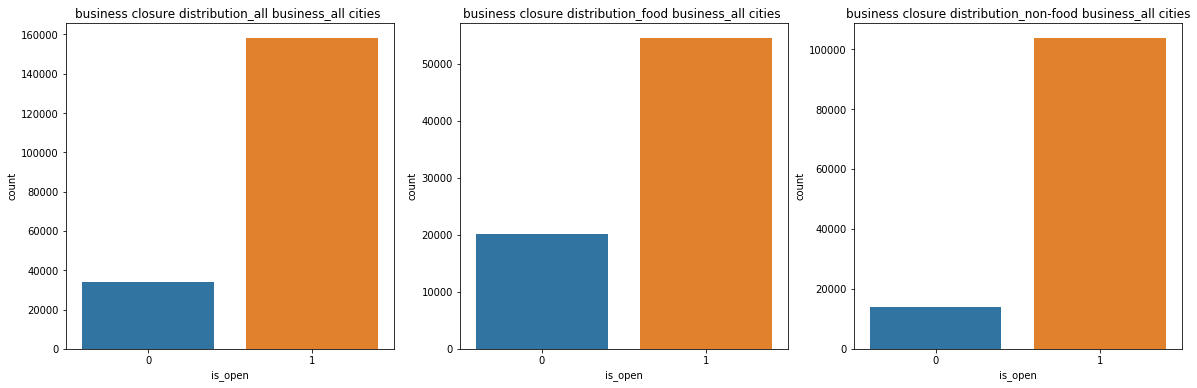

In [8]:
##############Business data frame, Separate food from non food ################
allcity_food=business[business['cat']==1]['business_id']
allcity_nonFood=business[business['cat']==0]['business_id']
# plot is_open for all city, separate food , non food
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.countplot(x='is_open',data=business);
plt.title("business closure distribution_all business_all cities ")
plt.subplot(1,3,2)
#plt.figure(figsize=(6,6))
sns.countplot(x='is_open',data=business[business['cat']==1]);
plt.title("business closure distribution_food business_all cities ")
plt.subplot(1,3,3)
sns.countplot(x='is_open',data=business[business['cat']==0]);
plt.title("business closure distribution_non-food business_all cities")

In [9]:
# how many reviews on food places 
print("number of reviews on food all cities:",yp_review.loc[yp_review['business_id'].isin(allcity_food)].shape[0])
print("number of reviews on non-food all cities:",yp_review.loc[yp_review['business_id'].isin(allcity_nonFood)].shape[0])

number of reviews on food all cities: 4580300
number of reviews on non-food all cities: 2103463


In [10]:
###########################################
#### Select City of Scottsdale ######
###########################################
#business_id for city == Toronto
#business categories is food
city='Scottsdale'#'Tempe' #'Toronto'
#business=business[business['cat']==1]
business=business[business['city']==city]  # change City of analysis: Tempe, Toronto;Scottsdale
bus_id=business['business_id']
len(bus_id) 
# Tempe: 1342 food places which is 30% of 4536 all business; Scottsdale:2004 food places is 22% of 8824 all business; 
# Toronto

8824

Text(0.5, 1.0, 'business closure distribution for non-food business Scottsdale')

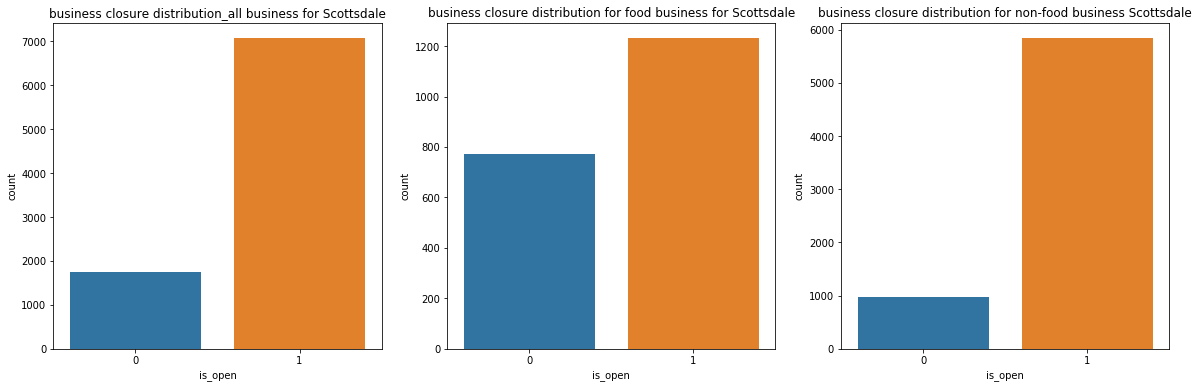

In [11]:
# plot is_open for selected city, separate food, non food
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.countplot(x='is_open',data=business);
plt.title("business closure distribution_all business for %s" % city)
plt.subplot(1,3,2)
#plt.figure(figsize=(6,6))
sns.countplot(x='is_open',data=business[business['cat']==1]);
plt.title("business closure distribution for food business for %s" % city)
plt.subplot(1,3,3)
sns.countplot(x='is_open',data=business[business['cat']==0]);
plt.title("business closure distribution for non-food business %s" % city)

# A. EDA on review for Scottsdale

In [12]:
business.city.value_counts().index #check if working on the right city
bus_id=business[business['cat']==1].business_id

In [13]:
# pick out reviews only from selected city on food business
review_df=yp_review[['review_id','business_id','text','stars','date']]
review_df = review_df.loc[review_df['business_id'].isin(bus_id)] # get review only for Scottsdale food business
print('unique food business_id in dataframe review_df for city %s'%city,review_df.business_id.unique().shape) 
# We should see unique business_id in dataframe review_df for city Scottsdale (2004,)
review_df.head(2)

unique food business_id in dataframe review_df for city Scottsdale (2004,)


,review_id,business_id,text,stars,date
7,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,This place has gone down hill. Clearly they h...,1,2010-10-05 19:12:35
32,CelUWzp-GnJIiiV1mDUb-g,CDpoJiqgM04wqQTZ6QkTqQ,Love this place downtown but the Scottsdale lo...,1,2015-12-05 02:37:03


In [14]:
print(review_df.shape)#Food only business: (128889, 3) for Tempe; (422050, 3) for TOronto; (246295, 3) for Scottsdale
# pickle the review_df
filename = 'review_df'
outfile = open(filename,'wb')
pickle.dump(review_df,outfile)
outfile.close()


(246295, 5)


In [15]:
# load pickled file back in and check data validity if can plot
filename = 'review_df'
infile = open(filename,'rb')
review_df= pickle.load(infile)
infile.close()
print(review_df.shape) # (422050, 3) for Toronto;(246295, 3) for Scottsdale
review_df.head(2)

(246295, 5)


,review_id,business_id,text,stars,date
7,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,This place has gone down hill. Clearly they h...,1,2010-10-05 19:12:35
32,CelUWzp-GnJIiiV1mDUb-g,CDpoJiqgM04wqQTZ6QkTqQ,Love this place downtown but the Scottsdale lo...,1,2015-12-05 02:37:03


#### Use earliest and latest review to calculate age of business

In [104]:
review_df['date_clean']=review_df['date'].astype(str).str[:10]
review_df['date_clean']=pd.to_datetime(review_df.date_clean)
#review_df['earliest']=review_df['date_clean']
#review_df['latest']=review_df['date_clean']
#review_df=review_df.iloc[:,:-1]
#review_df=review_df.iloc[:,:-1]
review_df.head(2)
#df = df.iloc[:, :-1] #delete the last columm

,level_0,index,review_id,business_id,text,stars,date,date_clean
0,0,7,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,This place has gone down hill. Clearly they h...,1,2010-10-05 19:12:35,2010-10-05
1,1,32,CelUWzp-GnJIiiV1mDUb-g,CDpoJiqgM04wqQTZ6QkTqQ,Love this place downtown but the Scottsdale lo...,1,2015-12-05 02:37:03,2015-12-05


In [83]:
#make index consistent
review_df = review_df.reset_index(drop=False)
review_df['earliest'][0]

Timestamp('2010-10-05 00:00:00')

In [95]:
len(bus_list) 

2004

In [160]:
################################
## WARNING!: run time long ##
##############################
from datetime import date
from dateutil.relativedelta import relativedelta
from dateutil import relativedelta as rdelta

# how to find the earlierst review for particular business_id?
# testing business_id q2KtxnPa6rPSpAlMbg9l8g
bus_list=list(bus_id) #q2KtxnPa6rPSpAlMbg9l8g
#print(bus_list[0])

# Creating an empty Dataframe with column names only
dfObj = pd.DataFrame(columns=['business_id', 'earliest', 'latest','age'])

start_time = time.time()
for i in range(len(bus_list)): #len(bus_list)
    print(i,bus_list[i])
    temp = review_df[review_df['business_id']==bus_list[i]]
    temp=temp.sort_values(by='date_clean') 
    #print(temp)
    print(temp.iloc[0,7])
    print(temp.iloc[temp.shape[0]-1,7]) # 2009-01-10 , 2018-11-12 
    
    # Append rows in Empty Dataframe by adding dictionaries
    dfObj = dfObj.append({'business_id':bus_list[i] , 'earliest':temp.iloc[0,7], 'latest': temp.iloc[temp.shape[0]-1,7]}, ignore_index=True)
  
    #review_df['earliest']=review_df['business_id'].apply(lambda x : temp.iloc[0,6] if x== bus_list[i] else review_df['earliest'][i] )
    #review_df['latest']=review_df['business_id'].apply(lambda x : temp.iloc[temp.shape[0]-1,6] if x== bus_list[i] else review_df['latest'][i] )
    
    #review_df[review_df['business_id']==bus_list[i]].earliest=temp.iloc[0,5]
    #review_df[review_df['business_id']==bus_list[i]].latest=temp.iloc[temp.shape[0]-1,5]
    #print(review_df[review_df['business_id']==bus_list[i]])
    
print("runtime--- %s seconds ---" % (time.time() - start_time))  


dfObj['earliest'] = dfObj['earliest'].apply(lambda x : pd.to_datetime(str(x)))
dfObj['earliest']= dfObj['earliest'].dt.date
dfObj['latest'] = dfObj['latest'].apply(lambda x : pd.to_datetime(str(x)))
dfObj['latest']=dfObj['latest'].dt.date

# calculate age for the business in days
dfObj['age']=(dfObj['latest']-dfObj['earliest'])

# extract days only
for i in range(len(bus_list)): #len(bus_list)
    dfObj['age'][i]=dfObj['age'][i].days
    
dfObj.head()

0 q2KtxnPa6rPSpAlMbg9l8g
2009-01-10 00:00:00
2018-11-12 00:00:00
1 nsNONDHbV7Vudqh21uicqw
2006-01-15 00:00:00
2018-11-09 00:00:00
2 MhnihE0alud0ereVInSt8Q
2010-06-20 00:00:00
2018-11-09 00:00:00
3 zfOum9_rEhaLAqoAV3nYaQ
2013-12-21 00:00:00
2015-07-16 00:00:00
4 d7iFE8GCz3S8eZGWEQoP6Q
2007-03-14 00:00:00
2018-10-31 00:00:00
5 QS3QxI7u5PRdtbGgI0-UsA
2006-01-12 00:00:00
2018-11-08 00:00:00
6 AMN3Sgns9tB2x-b3eWk0qQ
2007-06-15 00:00:00
2018-11-05 00:00:00
7 -bd4BQcl1ekgo7avaFngIw
2014-08-23 00:00:00
2018-11-04 00:00:00
8 ILA41PhErg4bl1royzDX4g
2017-01-20 00:00:00
2018-11-10 00:00:00
9 ncXQtqJT5Gk1QztwTrBrgw
2007-09-24 00:00:00
2018-11-11 00:00:00
10 aRNjAsmXv1pJTUWTtI7xlw
2011-07-10 00:00:00
2017-05-19 00:00:00
11 F5arCcVW_mjFWbgJbWYO-Q
2016-04-11 00:00:00
2018-11-10 00:00:00
12 9E1q2uEMd881wnruicNTUA
2013-07-31 00:00:00
2018-11-09 00:00:00
13 YrVoo51-y4jMxpZh-kPRfw
2007-12-29 00:00:00
2018-08-27 00:00:00
14 rubckw-nGtSDdhUiz7gOXQ
2013-11-11 00:00:00
2018-07-23 00:00:00
15 bGno_WKbepp48eqgU

2016-01-23 00:00:00
2018-09-10 00:00:00
130 04ZtW6rq8rPYD-kLhNY2_Q
2018-02-02 00:00:00
2018-11-13 00:00:00
131 ypcnpQxy-Cj6wPtcaR15eg
2011-05-16 00:00:00
2018-03-01 00:00:00
132 yQ8BbqjcdNmmcWMJTOYmvQ
2009-06-05 00:00:00
2018-07-27 00:00:00
133 SBNucLXc9dQP6VBj__XOmQ
2008-04-02 00:00:00
2018-11-07 00:00:00
134 cHzbYbyOokI86dpjN7gyDg
2008-01-25 00:00:00
2018-10-30 00:00:00
135 wOjcXM01_d6ovRzOP6H90w
2017-11-25 00:00:00
2018-05-21 00:00:00
136 ArQs--vHJtN7_m6hGH9EmQ
2012-03-05 00:00:00
2015-03-22 00:00:00
137 1VKjDpPJdVoiRc8I9f7U9g
2012-10-02 00:00:00
2018-10-28 00:00:00
138 1N0NhvtN1JmPlozjuY_QfQ
2008-05-10 00:00:00
2018-05-27 00:00:00
139 wH4Q0y8C-lkq21yf4WWedw
2015-01-18 00:00:00
2018-11-07 00:00:00
140 INZDJei7P1kG7l4ntBJ7hA
2018-04-15 00:00:00
2018-09-27 00:00:00
141 TBTVE-YzujCHrTqoAxL05A
2008-07-17 00:00:00
2018-10-29 00:00:00
142 FyfltLZgG67QS6i2jv2JoA
2015-05-15 00:00:00
2018-11-08 00:00:00
143 EdiHQlmH5xPS9HvfJXkPUg
2016-12-28 00:00:00
2018-11-02 00:00:00
144 kKfX_V-CouF9XyZaRh

2007-06-10 00:00:00
2018-02-24 00:00:00
259 W19GKChSpyRoaBlmNFTiWg
2010-02-03 00:00:00
2018-09-11 00:00:00
260 d10IxZPirVJlOSpdRZJczA
2011-01-19 00:00:00
2018-11-12 00:00:00
261 n6GEL5PDQ3ZvZ5HtxIhGFA
2015-05-03 00:00:00
2018-03-02 00:00:00
262 Wj_48yqBXHLgkmMh8QYhaA
2009-01-15 00:00:00
2012-06-17 00:00:00
263 pBFewLcdLnf1XwPTE4jtyQ
2012-11-18 00:00:00
2018-10-27 00:00:00
264 u-dkj1MrVHwVxFSzd_z-4g
2008-08-15 00:00:00
2018-09-13 00:00:00
265 0OxEVzBKDmTP7GdSmhi3ow
2014-07-04 00:00:00
2018-08-13 00:00:00
266 MiScfzRrYOSuN4Hxr5M9oQ
2011-02-28 00:00:00
2018-06-10 00:00:00
267 3p4M5be6uc1S78TO62gmOg
2011-09-29 00:00:00
2018-11-12 00:00:00
268 3u5el8pjsc6igwPlls0_6Q
2016-07-15 00:00:00
2018-10-26 00:00:00
269 9eoigne3SpoDbMpkVcHPog
2013-11-26 00:00:00
2015-07-12 00:00:00
270 l7Bab_ySoDlB-dxo6YVZXg
2018-04-07 00:00:00
2018-11-10 00:00:00
271 MBY8OO1ccxgB0Co6vQ35Ig
2015-02-17 00:00:00
2016-09-17 00:00:00
272 6zincCvQTb9BsuK-GHZ4cw
2008-03-04 00:00:00
2018-11-06 00:00:00
273 ef1tPKe8MjIuoiscXe

2006-10-18 00:00:00
2013-10-11 00:00:00
386 IVJ-zYNzVKVCbE08Xo88tw
2009-04-25 00:00:00
2014-01-12 00:00:00
387 bmQxZkn4hA8tEL-Z33pZKw
2012-02-04 00:00:00
2016-09-01 00:00:00
388 Ac7C2H4E363qVQEHpONLLw
2011-01-04 00:00:00
2015-07-15 00:00:00
389 pt4YdbpVeU6P7j8g_Bvsmw
2010-04-28 00:00:00
2011-12-25 00:00:00
390 WF05nlZiHqY9C8xwVtPhyA
2016-01-26 00:00:00
2018-11-13 00:00:00
391 IOgARa8yaXx12MXkvmc5og
2011-07-21 00:00:00
2014-02-03 00:00:00
392 sU26m6RAkTtaNUjiJUFqRw
2016-10-04 00:00:00
2018-09-22 00:00:00
393 KrYDbrvfZVTlmC6M89zd9g
2009-02-27 00:00:00
2018-10-26 00:00:00
394 RTegy5CUBpMK65pr8UeDgA
2006-05-17 00:00:00
2018-11-10 00:00:00
395 Wg4jlAgOUB51aX1c3ex9GQ
2017-06-21 00:00:00
2018-11-12 00:00:00
396 -GUi0xyzwT9KJPS0v96dRA
2008-11-04 00:00:00
2017-06-09 00:00:00
397 Rq6WYcNMX8VZohD89LGWaQ
2009-08-05 00:00:00
2018-11-13 00:00:00
398 CwIi9O0snlyV0DmyFlq1Kw
2010-04-04 00:00:00
2014-08-05 00:00:00
399 NeliCHhyXIHYVTnDyl7J1Q
2014-04-12 00:00:00
2018-11-04 00:00:00
400 x0y6TU_03x7ZOjzKCi

513 3hXDRfZR-Hwx3QKaEqa-Lg
2010-03-19 00:00:00
2018-09-04 00:00:00
514 qKS7YV76te6olKnA_aMPTg
2006-11-12 00:00:00
2018-05-14 00:00:00
515 p-qvtajJfi19y3Oz-pa9_A
2017-02-13 00:00:00
2018-10-17 00:00:00
516 h2hJyBYCIXU2_om6LYHWHA
2011-11-07 00:00:00
2017-06-05 00:00:00
517 zfeD4tImUPT8CznDrsn-mQ
2009-03-03 00:00:00
2012-12-15 00:00:00
518 aKvVbg35NUzudmS5ntQriA
2007-02-23 00:00:00
2014-06-16 00:00:00
519 Qc9BkjauJ79dd2Z7zMyg6w
2007-06-08 00:00:00
2008-03-31 00:00:00
520 gc80fMQ5WioX0opKjq7Iig
2016-03-23 00:00:00
2018-02-27 00:00:00
521 MGbZXur_FkGFBT15O9SFLQ
2013-10-04 00:00:00
2018-07-26 00:00:00
522 PS2s35zZsbdW3r_JjudFOA
2006-01-12 00:00:00
2015-09-27 00:00:00
523 nzbQXU2x7O8oucKGthUT3g
2007-11-13 00:00:00
2018-10-20 00:00:00
524 3ALmsWbXnVylkwkLGbc5uA
2014-03-26 00:00:00
2018-07-31 00:00:00
525 yKPFDjretpatajGn4O7FsQ
2017-12-20 00:00:00
2018-09-24 00:00:00
526 FW78hMpZoaJcZfUkBkgnLA
2014-09-03 00:00:00
2018-10-24 00:00:00
527 BiHIIwWOV71buviXGHf24w
2011-04-15 00:00:00
2011-05-15 00:0

2008-05-16 00:00:00
2014-04-22 00:00:00
637 JJBHGaZl9U9lFGBIoKExgQ
2011-03-06 00:00:00
2016-02-13 00:00:00
638 2OD-aBvnya2kiC2acEMHog
2008-10-21 00:00:00
2010-09-09 00:00:00
639 Blfn30Y8tvYq903oLiIf3g
2013-05-26 00:00:00
2018-11-05 00:00:00
640 TE1Tzy02Zj86LqmyY3DDOg
2006-08-07 00:00:00
2007-02-22 00:00:00
641 VeRHiEbUe_vHprYn8mnezA
2012-11-10 00:00:00
2018-11-10 00:00:00
642 zPQesAWNB_FuL2Be1pPPlA
2007-02-08 00:00:00
2018-11-08 00:00:00
643 u0_EMrcXuQW3zu39peNQzw
2013-06-05 00:00:00
2018-06-11 00:00:00
644 N1ei3ADwtUgrftAT4Yglrw
2008-04-04 00:00:00
2010-03-01 00:00:00
645 UotZUkpcI0p2J8RUAD36Ng
2014-02-18 00:00:00
2018-11-12 00:00:00
646 J8hSZ_LEdHHSk7yHe8LRzQ
2015-08-29 00:00:00
2018-11-06 00:00:00
647 Kx-FVuIdlnvPBXpJvcn5qw
2015-06-15 00:00:00
2015-12-27 00:00:00
648 pshiKbFYbE2P5dkXa0FVgg
2007-07-31 00:00:00
2018-10-03 00:00:00
649 6i4Sxo2dDvHU6lIiis0OUQ
2015-06-17 00:00:00
2018-08-15 00:00:00
650 gc5bZeAOoSvlK-gcJJHahA
2014-09-24 00:00:00
2016-08-26 00:00:00
651 Ryy16NcZtVB66ggWmK

2008-02-15 00:00:00
2018-10-08 00:00:00
767 6sKaAF8WhWyyCjfZr2Rfsg
2007-02-27 00:00:00
2018-10-27 00:00:00
768 QT1Qkjm2mFne5hfxmV1PIA
2018-07-21 00:00:00
2018-11-13 00:00:00
769 KZj3f5ohsyGfIer7K-xncg
2011-08-31 00:00:00
2012-02-28 00:00:00
770 za9qr9ZZWLTfEgTfogRbUw
2009-06-10 00:00:00
2018-10-12 00:00:00
771 yX2Iu4--Z6QK7kfEvvpgHg
2011-01-12 00:00:00
2011-06-03 00:00:00
772 sYX_x8GPm92pBRwbq_gTHQ
2013-06-29 00:00:00
2017-01-06 00:00:00
773 xADzoC8MpHx9PVid4AvaNQ
2012-06-15 00:00:00
2012-11-04 00:00:00
774 fCq3AVUzWDarScN020AcjQ
2014-12-21 00:00:00
2018-10-30 00:00:00
775 wfGWfnRfZR_jr1C13nhRLg
2011-11-29 00:00:00
2017-08-20 00:00:00
776 04HJrOusacroxbilmzrdvg
2018-04-17 00:00:00
2018-10-09 00:00:00
777 98zrbyncBdGRXQngWmSjOA
2011-12-23 00:00:00
2015-12-13 00:00:00
778 bb6-QOjO_3XWXwgKqRK3oQ
2012-05-07 00:00:00
2015-01-25 00:00:00
779 oVx4FarZkIYo87b8bh5QKQ
2009-05-21 00:00:00
2018-10-08 00:00:00
780 hRK876bEBdPYAJKbg6pCEw
2005-07-14 00:00:00
2018-11-11 00:00:00
781 oFBbCtYE_BvuCMsH-y

2013-02-17 00:00:00
2015-03-09 00:00:00
893 vWTiJmM07kbjShL3yjoOrg
2015-02-03 00:00:00
2018-11-13 00:00:00
894 QUSbn8n0FKhp4i1IU3hcAw
2012-03-27 00:00:00
2018-09-08 00:00:00
895 EkFKidOJKlknZPg9v_uzPw
2006-11-26 00:00:00
2018-09-30 00:00:00
896 WdujD5A32_9VJJ1PfojM6g
2012-02-03 00:00:00
2015-05-21 00:00:00
897 Jg0mxuXZbuCKI91TQtKwDA
2009-07-24 00:00:00
2018-11-04 00:00:00
898 y1SmeMZx5Q8pOKJsEv9IBA
2018-10-13 00:00:00
2018-11-01 00:00:00
899 cABJSn_Pw01tX7LhnvDTDA
2015-07-26 00:00:00
2018-06-03 00:00:00
900 c6lzPktduqtKqRSnX_CUTg
2017-03-29 00:00:00
2017-11-05 00:00:00
901 n2WUxe1YnEHIOwK1NJ1MkA
2017-07-06 00:00:00
2018-08-03 00:00:00
902 AcFmtQtWdV8NJuAORmBYiQ
2015-04-13 00:00:00
2015-07-12 00:00:00
903 GAi03qxW5L7jdZ9cMhr0vQ
2013-01-16 00:00:00
2018-06-30 00:00:00
904 pD0fh3uTKitXvwKWxqBOKg
2017-04-19 00:00:00
2018-10-30 00:00:00
905 DmKeLThDKrqOVdQEXBP2kA
2007-04-03 00:00:00
2018-10-10 00:00:00
906 Xd3CvDmkW9tnOpgEZ3_MVQ
2008-02-24 00:00:00
2009-10-18 00:00:00
907 MhfIrfnXj3jEO8Do77

2007-07-06 00:00:00
2016-08-21 00:00:00
1019 VF4KH9JVolOeo2XojphthQ
2016-05-31 00:00:00
2018-11-10 00:00:00
1020 a2NSxkmX0_eqvdwJ2rjPVg
2006-01-11 00:00:00
2018-11-10 00:00:00
1021 mreVfNDmhkQBPbWZ6vtr9w
2016-07-05 00:00:00
2017-11-12 00:00:00
1022 65iIzq80WQ1nMqj_rLWNYQ
2014-11-25 00:00:00
2018-09-11 00:00:00
1023 8c6hS7MqgJ2ZmZmFaXdSUA
2007-07-26 00:00:00
2008-07-15 00:00:00
1024 PpnHlk95jbeK261RHuXflw
2010-06-15 00:00:00
2015-08-21 00:00:00
1025 a11zyJN_ue0CQ_bjoeke-w
2006-01-14 00:00:00
2018-11-10 00:00:00
1026 YPsPMXxSc1LoYHRKmFklKA
2010-03-15 00:00:00
2018-01-10 00:00:00
1027 wknp5VJ8sz0-AsLkOI9CAA
2010-04-13 00:00:00
2018-06-14 00:00:00
1028 TwriSG0Gq9vr7n_Re1OR1A
2009-06-23 00:00:00
2014-05-27 00:00:00
1029 Da4E88htQ_FTOB9HgGcdBQ
2017-05-13 00:00:00
2017-12-20 00:00:00
1030 U3qe9h6I0zL2_C5m3-p1gw
2013-04-15 00:00:00
2015-11-19 00:00:00
1031 Jx5h4nIbANB4KDrb5l_v4w
2015-03-22 00:00:00
2018-11-05 00:00:00
1032 ouXG1yYRxEsZ_4gfhUob9g
2017-04-29 00:00:00
2018-11-08 00:00:00
1033 C2B

2012-11-23 00:00:00
2015-02-13 00:00:00
1143 VuCrxI61nT30OndMcrPgkA
2014-03-04 00:00:00
2018-11-10 00:00:00
1144 gc78dwGe4EP6resjJHJEbA
2007-06-27 00:00:00
2018-11-03 00:00:00
1145 LkmrqzFEImqzfKbJxSrwEA
2016-10-07 00:00:00
2018-11-07 00:00:00
1146 ApHiz1xxENwjkp8MKrE4Dg
2008-02-07 00:00:00
2018-10-20 00:00:00
1147 c3Ax5jq5kyekKWUgiaVJSw
2016-11-11 00:00:00
2018-11-04 00:00:00
1148 BcaA9jvHhuPoTJXz0RMZ6A
2008-07-23 00:00:00
2018-06-08 00:00:00
1149 nzxU5rmmObcj0eAR_0Vqew
2015-01-31 00:00:00
2018-07-17 00:00:00
1150 nFR7dDedxRuBeZz_6Cdalg
2007-05-29 00:00:00
2018-03-16 00:00:00
1151 oV0Zr6AR0XFSYCNRF9D4qA
2010-05-05 00:00:00
2011-06-13 00:00:00
1152 RmTjXHc2wF645_XlCo2ofw
2007-12-07 00:00:00
2018-05-31 00:00:00
1153 mIlwCZYr8uQH0mHJEhuf4g
2014-02-03 00:00:00
2017-08-12 00:00:00
1154 tzAMz3AA-hC2FS54Z0kMxQ
2016-09-16 00:00:00
2018-10-21 00:00:00
1155 LAx0h3NqySZhy6yWIHswLg
2008-03-17 00:00:00
2009-05-27 00:00:00
1156 hogj2UzWdiTgj8wnUQ0hTw
2010-02-24 00:00:00
2012-07-01 00:00:00
1157 bwp

2006-01-12 00:00:00
2018-11-11 00:00:00
1271 Y74pkciQCz8yryb_leMN0w
2010-05-27 00:00:00
2012-12-01 00:00:00
1272 jUd8qjDHq_zLAXVNQ3eeAQ
2012-12-04 00:00:00
2015-06-14 00:00:00
1273 YdRSx-i6uidsAO04GRMQVw
2009-04-05 00:00:00
2018-10-25 00:00:00
1274 _gnSt_cqn5XMmLuAhTdC4A
2014-12-06 00:00:00
2018-11-14 00:00:00
1275 scj1FBV05NVe0iQxplNNYw
2007-03-07 00:00:00
2014-06-21 00:00:00
1276 5mmF-H_4emxvultbneKFWQ
2007-07-06 00:00:00
2012-11-27 00:00:00
1277 uanXiHUBGq-6e6n5XwhzhA
2007-03-07 00:00:00
2018-11-09 00:00:00
1278 zgAecXWgPlkthxKPR6Dtcg
2016-03-29 00:00:00
2018-03-28 00:00:00
1279 o86OGfW63bVqWkIrvxcEQQ
2016-04-30 00:00:00
2018-11-12 00:00:00
1280 IYnwyLHhMtd1fqMQMJiSZA
2013-02-28 00:00:00
2016-11-16 00:00:00
1281 0qOI8lOZvvhrbtxqjaBQMg
2008-02-01 00:00:00
2018-11-07 00:00:00
1282 QDvUdj36I_oAzXoFzCQnNA
2008-03-18 00:00:00
2018-11-11 00:00:00
1283 UozyHLgexaM6yQJvR1BQJg
2013-10-05 00:00:00
2018-04-23 00:00:00
1284 R7Zh-nQfq6RjKnKdV_j2xw
2012-04-27 00:00:00
2017-11-15 00:00:00
1285 wEc

2007-12-25 00:00:00
2009-02-04 00:00:00
1398 fPj6-EoU8S5DN3rKZ1gutQ
2009-07-29 00:00:00
2010-03-23 00:00:00
1399 e4x3bLi6FXxi5Qkq3yUUnw
2012-02-17 00:00:00
2012-08-03 00:00:00
1400 xko9a0myoKffQMzz96O2jA
2008-02-05 00:00:00
2015-02-13 00:00:00
1401 _qKen2vDGWw11k71ibJ1Yw
2010-09-21 00:00:00
2018-10-27 00:00:00
1402 4LB4xtFAwfvJRachr6Eaxw
2007-10-04 00:00:00
2018-10-23 00:00:00
1403 i_kbQJodkcib4OawRuOZag
2018-01-26 00:00:00
2018-10-12 00:00:00
1404 EbGlh6Vd17jKVMmSPcGBUQ
2009-08-11 00:00:00
2013-01-10 00:00:00
1405 odVKlMYqb4FHJXManv-VRA
2013-05-01 00:00:00
2018-10-15 00:00:00
1406 OY0-hYJ2q6WiAqhYnCZZ0w
2012-07-02 00:00:00
2018-11-05 00:00:00
1407 BSpXnwBVR5tdcBT0s7mkeA
2007-04-16 00:00:00
2008-07-15 00:00:00
1408 mVihMz8zC-MdRPEgnMso2A
2013-05-19 00:00:00
2014-11-17 00:00:00
1409 mLj1xf3Za6PAoEYsddOOOQ
2011-05-04 00:00:00
2018-09-24 00:00:00
1410 jgmKcZsgKYkTFyYIabL3Sg
2010-07-06 00:00:00
2018-10-13 00:00:00
1411 _7FdoBvlZH64Zx52ISc59Q
2014-03-10 00:00:00
2015-11-07 00:00:00
1412 ZyK

2016-02-26 00:00:00
2018-10-31 00:00:00
1528 q7LTZeYP71cY15_ff4puqw
2018-02-26 00:00:00
2018-08-05 00:00:00
1529 -yWvniZVC6TjhnnptXRVrA
2013-06-13 00:00:00
2015-09-19 00:00:00
1530 Quayv4ZFz7z9xKQHnXbQQg
2013-12-07 00:00:00
2015-07-21 00:00:00
1531 _263Hi0kMpEGg6dtBXB3ag
2006-02-27 00:00:00
2015-11-16 00:00:00
1532 tz30FR-yQi-jNHPb7B-gBw
2006-02-27 00:00:00
2018-11-03 00:00:00
1533 o_W4cyIyPMZT4aNXbDT_uw
2011-11-03 00:00:00
2018-05-15 00:00:00
1534 0kyhbUW6NkpYjJzFBZ64vQ
2010-01-05 00:00:00
2015-07-19 00:00:00
1535 -kzdfAFoqPpJU903Zt_aeA
2008-04-27 00:00:00
2017-05-19 00:00:00
1536 4wQWc6N0VfwVqCNxrurrSQ
2015-04-20 00:00:00
2018-10-09 00:00:00
1537 T1rtbmM-pQ2rpUQpo_oo5Q
2008-08-25 00:00:00
2009-02-11 00:00:00
1538 BjbokieOGk2CCq2t8wV6MA
2014-11-15 00:00:00
2018-11-09 00:00:00
1539 7sv4L6ZV35rqF9-rH5R_3w
2009-03-16 00:00:00
2013-12-03 00:00:00
1540 6F9cnQ1fN8u8hNuMu9Ds9w
2010-07-29 00:00:00
2017-04-25 00:00:00
1541 ITc7sL3YYxHoQYoPNNH_GA
2016-01-17 00:00:00
2018-09-06 00:00:00
1542 BUd

2016-02-14 00:00:00
2018-03-06 00:00:00
1650 wOJ3NMhumJDs9FKDADa0AQ
2014-07-18 00:00:00
2016-05-24 00:00:00
1651 xIbtbAJLWLNZcqfqF4f-Nw
2013-03-05 00:00:00
2018-11-10 00:00:00
1652 ZQqiZAC4H4SI82W3RmaTKA
2008-03-06 00:00:00
2018-11-04 00:00:00
1653 mm0qwYzOilFNVV2us5_8Rg
2010-04-24 00:00:00
2018-11-06 00:00:00
1654 bawlqVxxnTbdYLuAtI8CJA
2015-04-01 00:00:00
2018-08-29 00:00:00
1655 VLDFjeqpUgWhnVuB_8GuEg
2010-11-13 00:00:00
2018-11-14 00:00:00
1656 _5Se2W5k_WJuee-aqBpNPA
2017-01-16 00:00:00
2018-11-13 00:00:00
1657 LpHi2ooFxVn5Ntttw_IcaQ
2008-04-21 00:00:00
2018-11-09 00:00:00
1658 YuxKSOAIYhuqFdMUW_xVsA
2013-12-10 00:00:00
2018-07-10 00:00:00
1659 Rubh4UGWy5-JaR_tsmuizg
2010-10-24 00:00:00
2012-06-28 00:00:00
1660 Mkb7dYT-tBGQPy6tUpWMKA
2014-03-19 00:00:00
2018-11-11 00:00:00
1661 mecL8UGi_Qm5be2t1L4B3w
2015-08-14 00:00:00
2018-11-07 00:00:00
1662 B5gvashBTJegCwLMdb9J2A
2008-05-06 00:00:00
2018-11-06 00:00:00
1663 gVLzkqIAHIWro_ZxkpjbFg
2017-08-19 00:00:00
2018-11-11 00:00:00
1664 ypQ

2012-12-15 00:00:00
2018-11-10 00:00:00
1775 _2zteKyb7si8VxMpGNYpxQ
2011-07-22 00:00:00
2018-10-14 00:00:00
1776 Hb8pO9jpr4IeB6cFcVZxxA
2012-04-28 00:00:00
2017-12-12 00:00:00
1777 DpCdZ3EfAoGgJzcvaR0quQ
2017-08-27 00:00:00
2018-09-23 00:00:00
1778 jlFXBqjNIJFHOTpE3tLgjA
2012-08-16 00:00:00
2017-01-28 00:00:00
1779 OnX2tH8ocYCVbMgsSOBXxw
2012-12-02 00:00:00
2018-08-07 00:00:00
1780 st_pnALlGB6OCWkb4e14mg
2006-08-05 00:00:00
2009-08-03 00:00:00
1781 8vnQAJ3zzI-iX_d0SI7BUA
2006-08-12 00:00:00
2016-09-07 00:00:00
1782 qMNgGd-9gsQDjalAquj4dQ
2007-08-21 00:00:00
2011-12-23 00:00:00
1783 6D4L8YpkhAh_YwaLmhoMNg
2007-02-07 00:00:00
2017-04-23 00:00:00
1784 PzdI7yM9GrufH6oavO6odg
2008-05-16 00:00:00
2018-11-02 00:00:00
1785 fDqRqsEHHb2njcFZ17CfVQ
2009-06-07 00:00:00
2018-06-29 00:00:00
1786 B8dETQdHa6tTzNvZWlOpiQ
2010-04-27 00:00:00
2011-04-23 00:00:00
1787 bs0PLtVoePk0UFwEWOCH5A
2017-08-05 00:00:00
2018-11-10 00:00:00
1788 6J4N91XIm_NORvPGy5lbfw
2017-02-05 00:00:00
2018-08-22 00:00:00
1789 0LK

1901 Xs2iTWxbczvfEapAFH3cyw
2010-12-21 00:00:00
2018-11-03 00:00:00
1902 _n3w5BK4-k7iXCWifCjUZg
2008-11-30 00:00:00
2015-03-18 00:00:00
1903 yWBus94VvCyXYNuXpoEpCg
2016-02-19 00:00:00
2018-11-13 00:00:00
1904 8un5h1h8NXs0hzeVraaPbA
2007-12-13 00:00:00
2018-11-11 00:00:00
1905 pEAK3gldYMwpuJfdn8y2Ew
2008-03-01 00:00:00
2018-10-05 00:00:00
1906 TfcQhrjJco0C_x0KVK7LwA
2006-01-09 00:00:00
2018-11-12 00:00:00
1907 4sfof0u2L7_ryXQusDM-aA
2014-09-12 00:00:00
2016-08-01 00:00:00
1908 x2lISX5DrWk4EvU9dspbJw
2010-03-24 00:00:00
2017-07-15 00:00:00
1909 K64Uw3a2Enh2MznpwRHWKQ
2006-12-31 00:00:00
2018-11-09 00:00:00
1910 SZrrRRpbUgeJ1y5oe0jjlw
2013-06-24 00:00:00
2018-10-20 00:00:00
1911 D4x9peZuBkps6j6T2WRpDA
2012-11-19 00:00:00
2013-06-07 00:00:00
1912 WZNcffmtdhCRcM8ikUMfPg
2010-12-18 00:00:00
2011-04-12 00:00:00
1913 TUVtxnT471P1UibiNNnVSg
2007-06-14 00:00:00
2011-12-03 00:00:00
1914 tTR9GQbdC-rEHNsECmSWRw
2008-09-03 00:00:00
2018-11-12 00:00:00
1915 1d6c6Q2j2jwVzBfX_dLHlg
2005-11-11 00:00:00


C:\Users\JayZ2\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\JayZ2\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,business_id,earliest,latest,age
0,q2KtxnPa6rPSpAlMbg9l8g,2009-01-10,2018-11-12,3593
1,nsNONDHbV7Vudqh21uicqw,2006-01-15,2018-11-09,4681
2,MhnihE0alud0ereVInSt8Q,2010-06-20,2018-11-09,3064
3,zfOum9_rEhaLAqoAV3nYaQ,2013-12-21,2015-07-16,572
4,d7iFE8GCz3S8eZGWEQoP6Q,2007-03-14,2018-10-31,4249


In [228]:
for i in range(len(bus_list)): #len(bus_list)
    #dfObj['earliest'][i]=float(dfObj['earliest'][i])
    #dfObj['latest'][i]=float(dfObj['lates'][i])
    dfObj['age'][i]=float(dfObj['age'][i])
    
dfObj['age_yr']=dfObj['age']/365.25



,business_id,earliest,latest,age,age_yr
count,2004,2004,2004,2004.0,2004.000000
unique,2004,1545,898,1580.0,1580.000000
top,hFvQisNsIo6E26o04W6u3Q,2006-08-08,2018-11-12,696.0,0.884326
freq,1,10,79,5.0,5.000000


              business_id    earliest      latest   age   age_yr
0  q2KtxnPa6rPSpAlMbg9l8g  2009-01-10  2018-11-12  3593   9.8371
1  nsNONDHbV7Vudqh21uicqw  2006-01-15  2018-11-09  4681  12.8159
2  MhnihE0alud0ereVInSt8Q  2010-06-20  2018-11-09  3064  8.38877
3  zfOum9_rEhaLAqoAV3nYaQ  2013-12-21  2015-07-16   572  1.56605
4  d7iFE8GCz3S8eZGWEQoP6Q  2007-03-14  2018-10-31  4249  11.6331


Text(0.5, 0, 'age_yr')

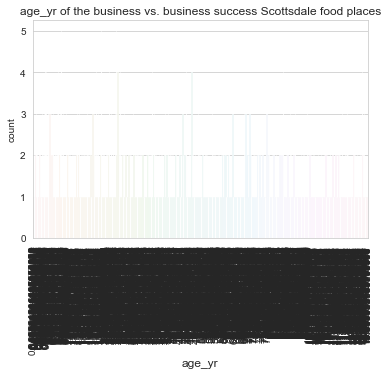

In [234]:
print(dfObj.head())
plt.figure(figsize=(6,4))
ax=sns.countplot(x='age_yr',data=dfObj,alpha=0.8);
plt.title("age_yr of the business vs. business success %s food places" %city)
plt.xticks(rotation=90)
plt.xlabel('age_yr', fontsize=12)

#### dfObj is ready to be merged with to Sentiment_by_Bus, see below at end of A. Sentiment Analysis on Review Text

# B. Sentiment Analysis on Review Text - Scottsdale Food

##### Below chucks can be skipped, just load in the pickled file 

In [67]:
df=review_df[['review_id','business_id','text']]
print(df.shape)  # check size to make sure is the right City,(246295, 3) for Scottsdale
df.head(2) #(246295, 3)

(246295, 3)


,review_id,business_id,text
0,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,This place has gone down hill. Clearly they h...
1,CelUWzp-GnJIiiV1mDUb-g,CDpoJiqgM04wqQTZ6QkTqQ,Love this place downtown but the Scottsdale lo...


In [68]:
#analysis on the entire review rather than all the words.
df_review_str=df['text'].astype(str)
print(df_review_str.shape) 
#(430985,) was the size for just toronto and run forever, with filter on food (422050) still too high
# 246295 for scottsdale food

(246295,)


In [70]:
df_review_str[0:10] 

0    This place has gone down hill.  Clearly they h...
1    Love this place downtown but the Scottsdale lo...
2    Sadly this place has been sold.  The gas price...
3    This is my first yelp.  This restaurant was so...
4    I used to work food service and my manager at ...
5    After being a HUGE fan of the Mission I decide...
6    Was very excited for happy hour and heard grea...
7    The brussel sprout nachos are really as good a...
8    This place rules! Best tacos in town and not t...
9    Came here while in town for a country concert....
Name: text, dtype: object

In [71]:
import pickle
filename = 'df_review_str_Scottsdale_Food'
outfile = open(filename,'wb')
pickle.dump(df_review_str,outfile)
outfile.close()

In [ ]:
########### LONG RUN TIME  ########## 
########## Run on Google Colab #####
from textblob import TextBlob

bloblist_desc = list()

start_time = time.time() 
# Tempe (128,889,) ran for runtime: --- 4302.755198478699 seconds --- 1.1hr
#for row in df_review_str[0:430,985]:
for row in df_review_str:
    
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])
print("runtime: --- %s seconds ---" % (time.time() - start_time))

##### Load in Pickled file with sentiment scores

In [164]:
## get pickled file from Google Colab drive
## load in pickled file to see sentiment score
filename = 'df_polarity_desc_Scottsdale'
infile = open(filename,'rb')
df_polarity_desc= pickle.load(infile)
infile.close()

df_polarity_desc.head()

,Review,sentiment,polarity
0,This place has gone down hill. Clearly they h...,-0.048611,0.350278
1,Love this place downtown but the Scottsdale lo...,0.166667,0.333333
2,Sadly this place has been sold. The gas price...,0.027083,0.566667
3,This is my first yelp. This restaurant was so...,0.583750,0.648333
4,I used to work food service and my manager at ...,0.194231,0.472222


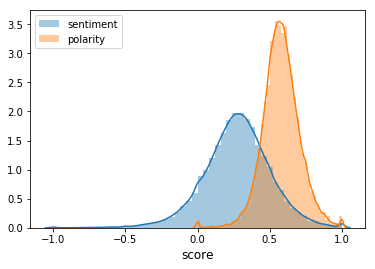

Text(0.5, 1.0, 'boxplot of polarity')

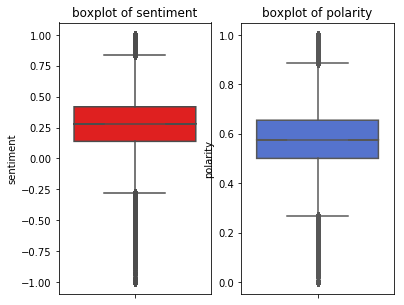

In [165]:
# distribution of sentiment score
ax=sns.distplot(df_polarity_desc['sentiment'],label="sentiment")
ax=sns.distplot(df_polarity_desc['polarity'],label="polarity")
#ax.legend(['sentiment', 'polarity'])
ax.legend()
plt.xlabel('score', fontsize=12)
plt.show()

plt.figure(figsize=(6,5))
plt.subplot(1,2,1)
ax=sns.boxplot(y=df_polarity_desc['sentiment'], color='red',orient='v', notch=True)
plt.title("boxplot of sentiment")
plt.subplot(1,2,2)
ax=sns.boxplot(y=df_polarity_desc['polarity'], color='royalblue',orient='v', notch=True)
plt.title("boxplot of polarity")

Boxplot shows that positive, negative, neutral division can be >0.2 is positive, < 0 is negative, rest neutral

In [166]:
# define postive, negative and neutral review
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0.2:
        val = 1 #"Positive Review": greater than 0.2 sentiment score
    elif df_polarity_desc['sentiment'] < 0:
        val = -1 #"Negative Review": below -0.2 sentiment score
    else:
        val = 0 #"Neutral Review" 
    return val

Text(0.5, 1.0, 'Postive is Sentiment > 0.2, Negative is <0, Rest is Neutral')

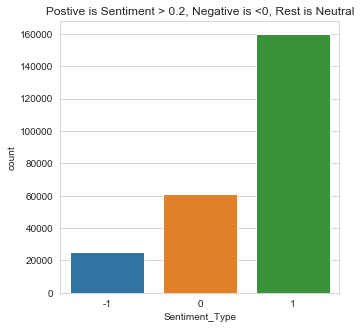

In [167]:
# create label for sentiment
df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)
plt.title("Postive is Sentiment > 0.2, Negative is <0, Rest is Neutral")
# comment: mostly postive reviews we can look at the most freq used words in postiive reviews

In [168]:
# sepearately look at postive negative reviews
positive_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']==1]
negative_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']==-1]

In [169]:
negative_reviews.head() # looks like services is the most complain

,Review,sentiment,polarity,Sentiment_Type
0,This place has gone down hill. Clearly they h...,-0.048611,0.350278,-1
16,The only thing I found interesting about the p...,-0.287500,0.690000,-1
21,Came here on a whim to try it out with my fian...,-0.121807,0.587446,-1
24,OPH all over this country is amazing. I've enj...,-0.066667,0.777778,-1
26,This place is gross. It was understaffed. I wa...,-0.207738,0.578869,-1


In [170]:
# Define world cloud
from wordcloud import WordCloud, STOPWORDS
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

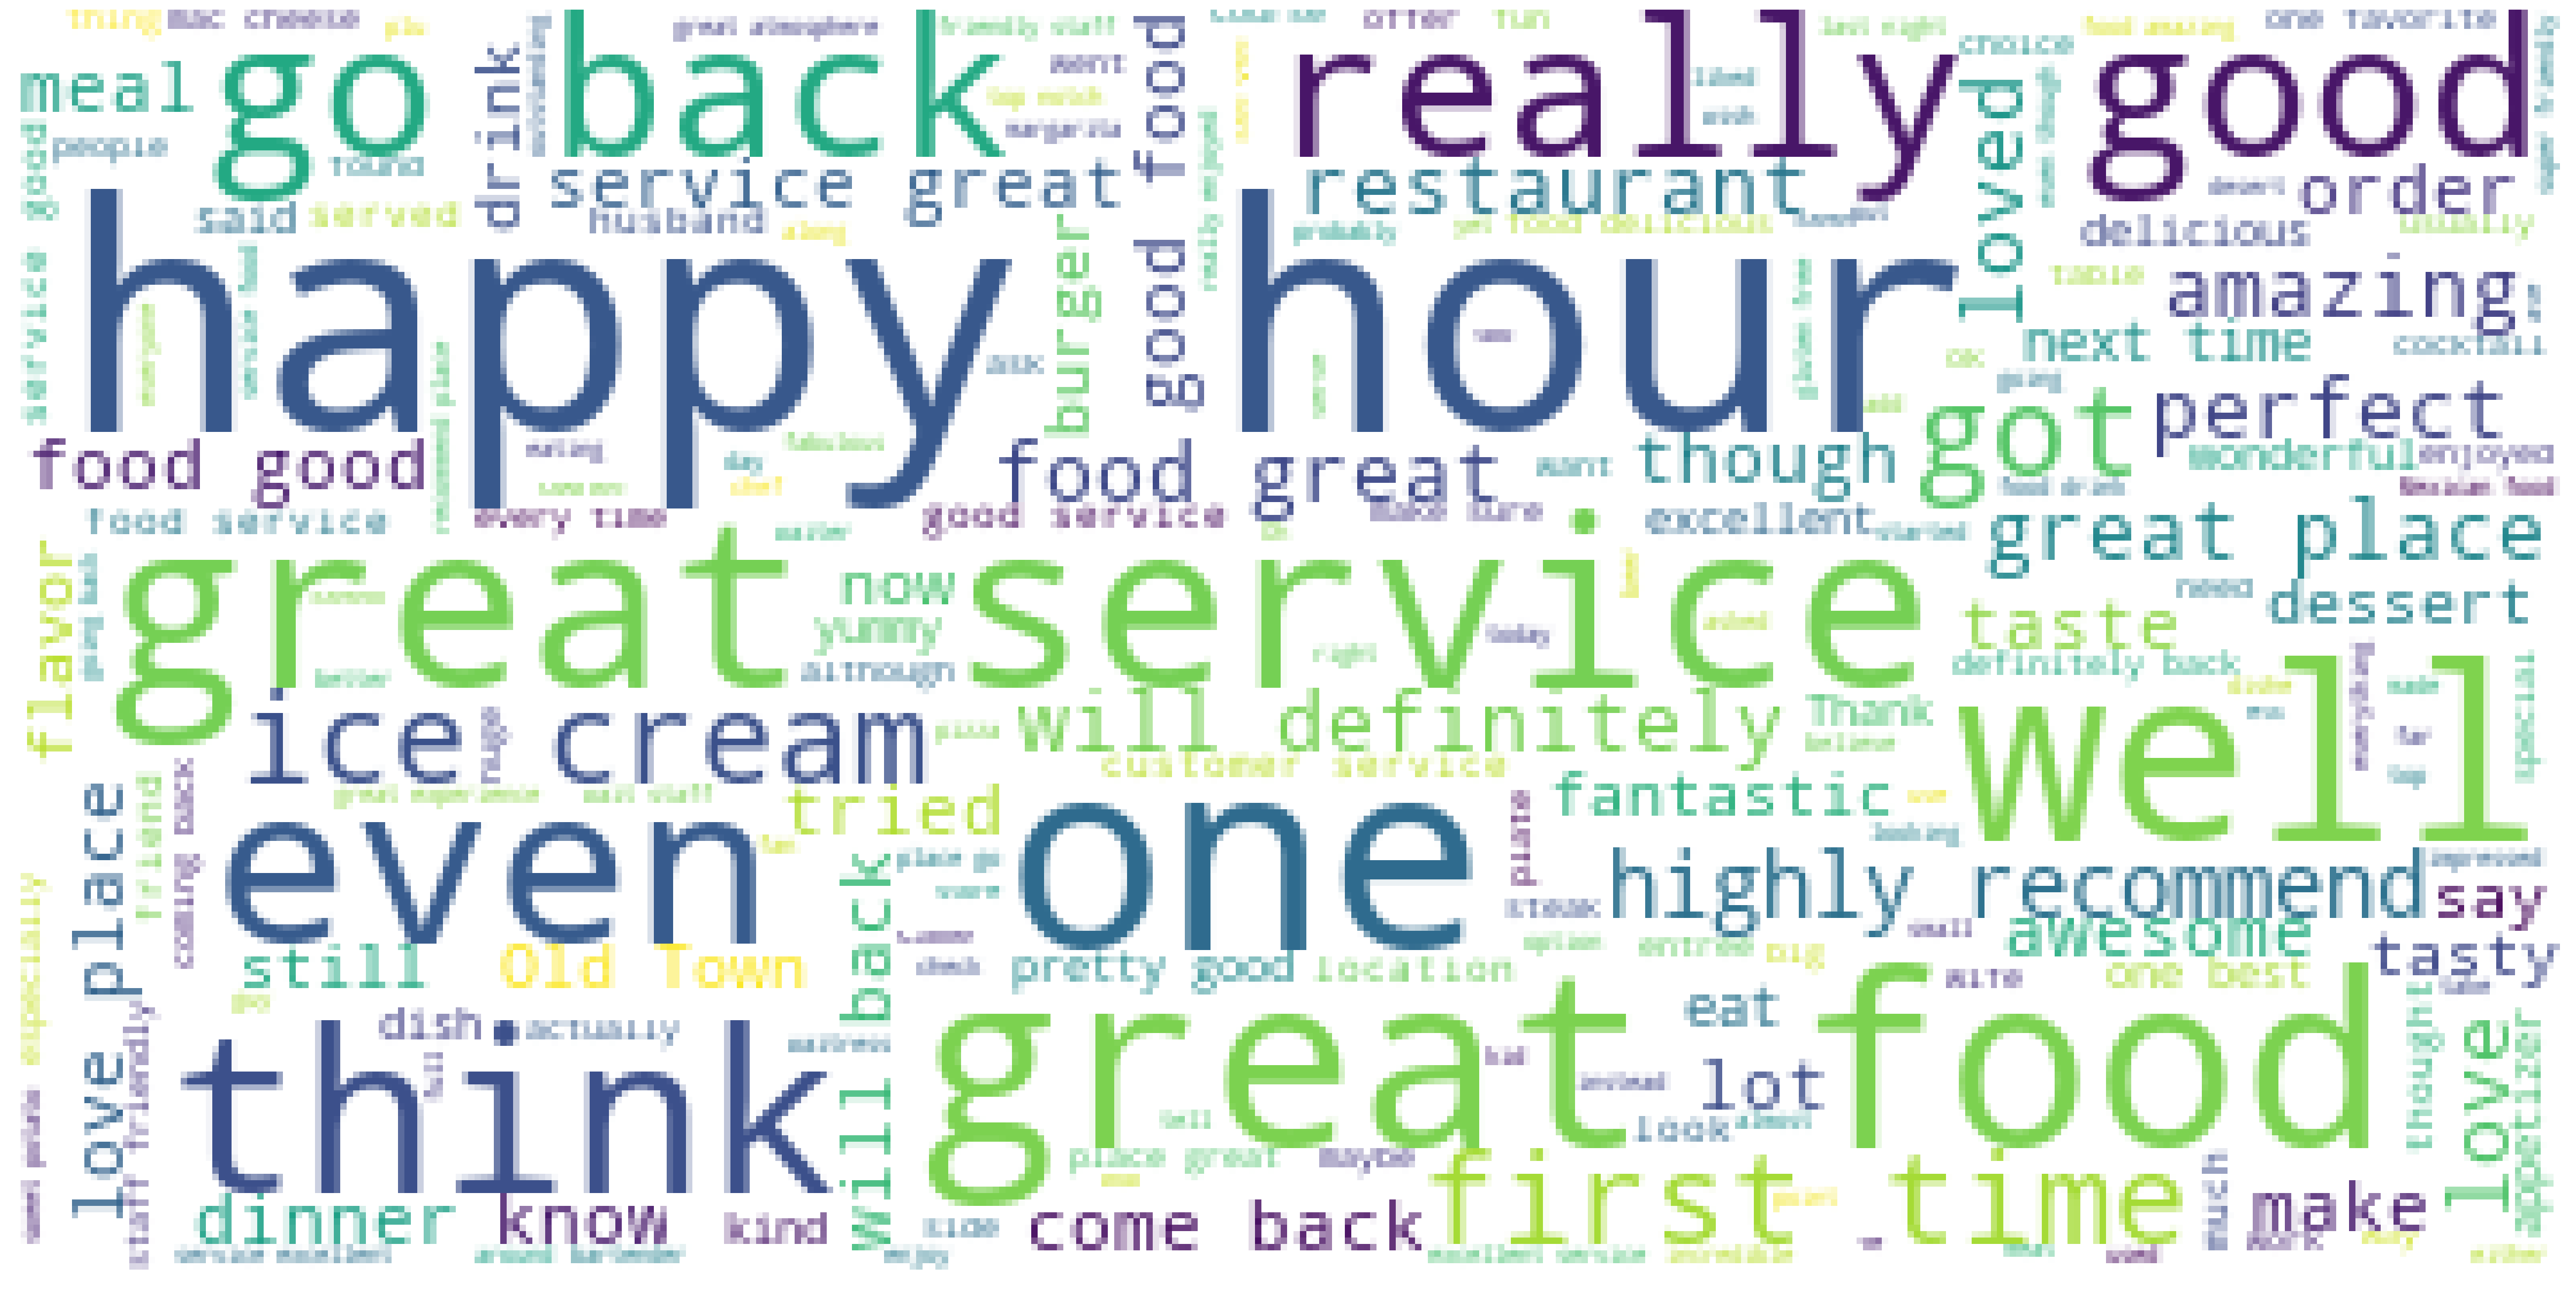

In [172]:
wc(positive_reviews['Review'],'white','Most Used Words')     # World cloud for most used words in a postive review

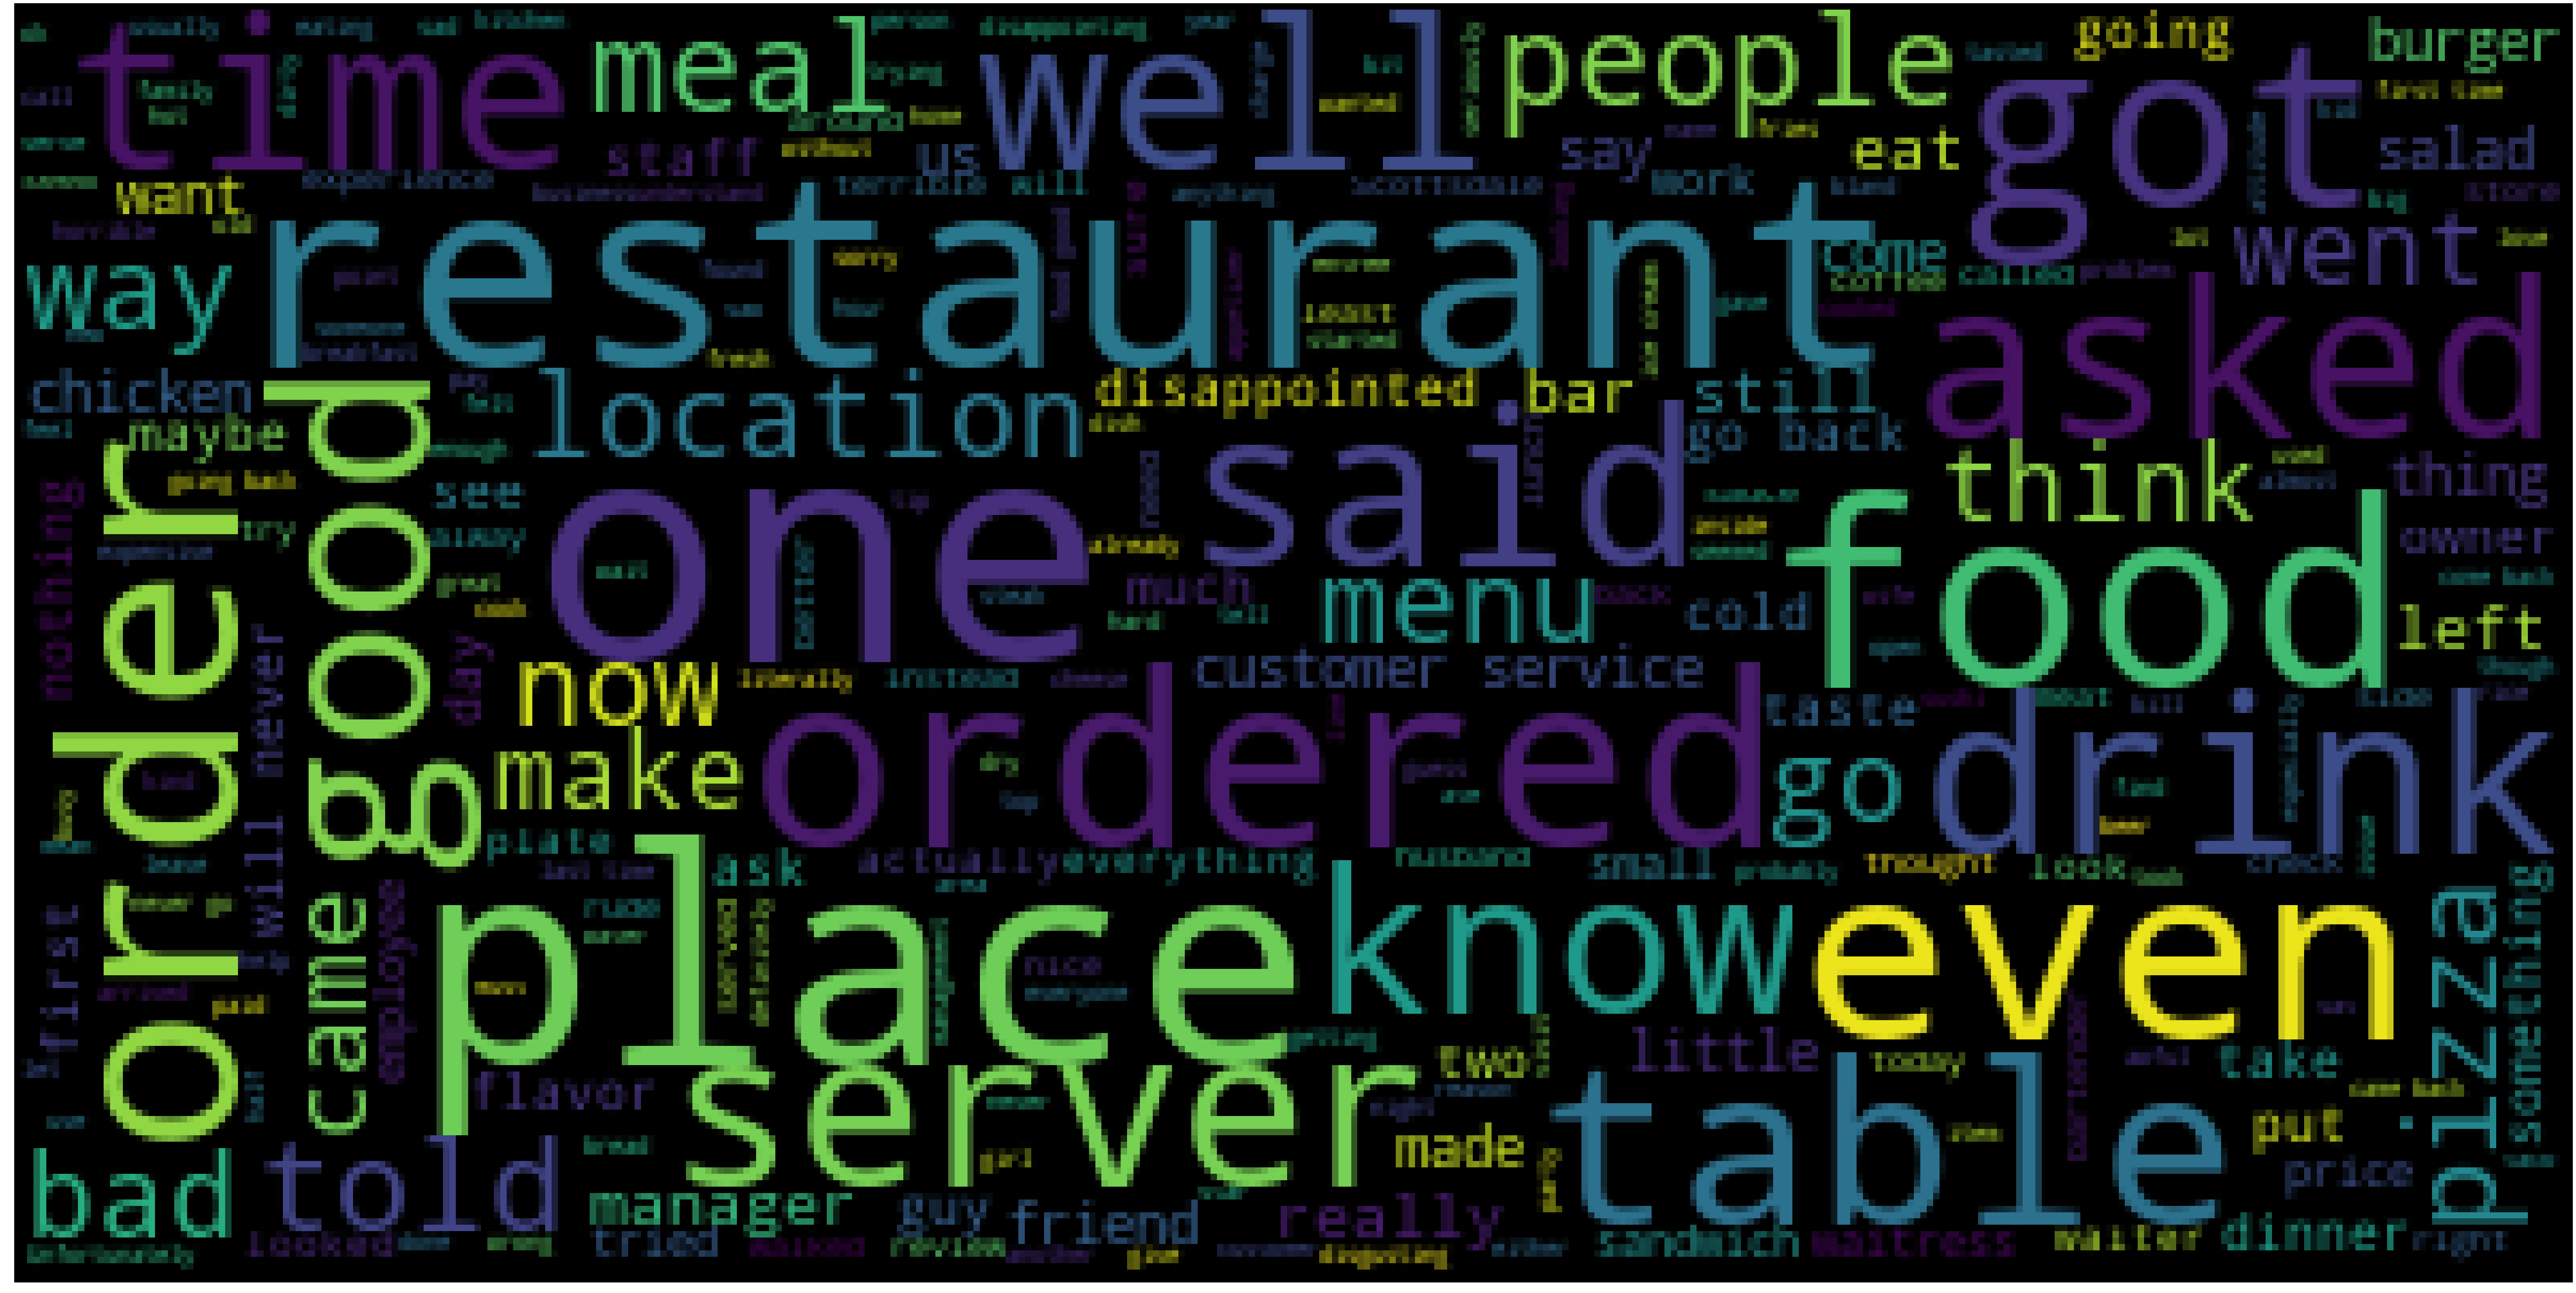

In [173]:
wc(negative_reviews['Review'],'black','Most Used Words') ## World cloud for most used words in a negative review
### Challenge: in ordr to product the targeted service improvement, need to crete a list of stop word such as restaurant, 

In [174]:
df_polarity_desc.tail() # Note the index is not the same for review_df

,Review,sentiment,polarity,Sentiment_Type
246290,This is a hidden gem in old town Scottsdale. ...,0.330208,0.518750,1
246291,I think this is a place for people who don't u...,-0.129167,0.395000,-1
246292,"This place was so convenient, fast, and not at...",0.371154,0.434615,1
246293,Cuteology Cakes created a cake for my Father o...,0.595238,0.761905,1
246294,I think this owner and the owner of Amy's Baki...,0.000000,0.000000,0


In [175]:
#make index consistent
#review_df = review_df.reset_index(drop=False)
review_df.tail(2)

,level_0,index,review_id,business_id,text,stars,date,date_clean
246293,246293,6685887,fnPw5DKCCOZ8a6fWTspZCg,X6XTiVnFH8_YNb5EvSZHsw,Cuteology Cakes created a cake for my Father o...,5,2010-06-27 02:16:17,2010-06-27
246294,246294,6685896,jPCXuSBbI_cPocgoNBhdkg,yA6dKNm_zl1ucZCnwW8ZCg,I think this owner and the owner of Amy's Baki...,1,2013-05-22 15:32:08,2013-05-22


In [177]:
print(review_df.shape)
print(df_polarity_desc.shape)
print(df_polarity_desc.isnull().sum())
print(review_df.isnull().sum())

(246295, 8)
(246295, 4)
Review            0
sentiment         0
polarity          0
Sentiment_Type    0
dtype: int64
level_0        0
index          0
review_id      0
business_id    0
text           0
stars          0
date           0
date_clean     0
dtype: int64


In [185]:
review_df.head(2)

,level_0,index,review_id,business_id,text,stars,date,date_clean
0,0,7,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,This place has gone down hill. Clearly they h...,1,2010-10-05 19:12:35,2010-10-05
1,1,32,CelUWzp-GnJIiiV1mDUb-g,CDpoJiqgM04wqQTZ6QkTqQ,Love this place downtown but the Scottsdale lo...,1,2015-12-05 02:37:03,2015-12-05


In [186]:
# next merge df or review_df with df_polarity_desc, after checking their row matches
#df = pd.concat([review_df, df_polarity_desc.iloc[:,2:4]],ignore_index=True)
#df=review_df[]
df=pd.DataFrame()
df['review_id']= review_df.review_id
df['business_id']= review_df.business_id#review_df.iloc[:,3]
df['stars']= review_df.stars#iloc[:,4]
df['date_clean']= review_df.date_clean#iloc[:,7]
df['sentiment']=df_polarity_desc.iloc[:,1]
df['polarity']=df_polarity_desc.iloc[:,2]
#df['polarity']=df_polarity_desc.polarity
df['sentiment_type']=df_polarity_desc.Sentiment_Type
print(df.isnull().sum())
df.head(2)

review_id         0
business_id       0
stars             0
date_clean        0
sentiment         0
polarity          0
sentiment_type    0
dtype: int64


,review_id,business_id,stars,date_clean,sentiment,polarity,sentiment_type
0,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,1,2010-10-05,-0.048611,0.350278,-1
1,CelUWzp-GnJIiiV1mDUb-g,CDpoJiqgM04wqQTZ6QkTqQ,1,2015-12-05,0.166667,0.333333,0


In [187]:
# eye check if dataframe is correct after combine info
print(df.head())
print(df_polarity_desc.head())
print(review_df.head())

                review_id             business_id  stars date_clean  \
0  8e9HxxLjjqc9ez5ezzN7iQ  zvO-PJCpNk4fgAVUnExYAA      1 2010-10-05   
1  CelUWzp-GnJIiiV1mDUb-g  CDpoJiqgM04wqQTZ6QkTqQ      1 2015-12-05   
2  h2lt2Lu8a9jUtYEbB2krhA  oSDyex506Y8H7YegcRb_9g      2 2016-06-22   
3  XRCS5zr29DOxlCXKKKwwAw  ZLuWpmvO41w2bSwufgfUlQ      5 2010-08-20   
4  lDJIaF4eYRF4F7g6Zb9euw  r5PLDU-4mSbde5XekTXSCA      4 2013-01-27   

   sentiment  polarity  sentiment_type  
0  -0.048611  0.350278              -1  
1   0.166667  0.333333               0  
2   0.027083  0.566667               0  
3   0.583750  0.648333               1  
4   0.194231  0.472222               0  
   level_0  index               review_id             business_id  \
0        0      7  8e9HxxLjjqc9ez5ezzN7iQ  zvO-PJCpNk4fgAVUnExYAA   
1        1     32  CelUWzp-GnJIiiV1mDUb-g  CDpoJiqgM04wqQTZ6QkTqQ   
2        2     60  h2lt2Lu8a9jUtYEbB2krhA  oSDyex506Y8H7YegcRb_9g   
3        3    103  XRCS5zr29DOxlCXKKKwwAw  ZLuWpmvO

In [188]:
# eye check if dataframe is correct after combine info
print(df.tail())
print(df_polarity_desc.tail())
print(review_df.tail())

                     review_id             business_id  stars date_clean  \
246290  wo4A7clfgo3VTjGTrx76lw  4U44KlOxvGG96pxtYYLR5A      5 2018-08-10   
246291  WNMtxgrJ_x9QuIuO_eZIwA  2r6UD7ExSMrK0LGeglquDA      2 2018-11-07   
246292  3hynJO9nhrkamssoZxg__Q  AVCD-zzzeaNvC-znOZEhsg      5 2018-11-09   
246293  fnPw5DKCCOZ8a6fWTspZCg  X6XTiVnFH8_YNb5EvSZHsw      5 2010-06-27   
246294  jPCXuSBbI_cPocgoNBhdkg  yA6dKNm_zl1ucZCnwW8ZCg      1 2013-05-22   

        sentiment  polarity  sentiment_type  
246290   0.330208  0.518750               1  
246291  -0.129167  0.395000              -1  
246292   0.371154  0.434615               1  
246293   0.595238  0.761905               1  
246294   0.000000  0.000000               0  
                                                   Review  sentiment  \
246290  This is a hidden gem in old town Scottsdale.  ...   0.330208   
246291  I think this is a place for people who don't u...  -0.129167   
246292  This place was so convenient, fast, and not

##### Pickle the files by City Name for the Current Run

In [189]:
### pickle this Scottsdale sentiment score file
import pickle
filename = 'Sentiment_Scottsdale_Food'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()

In [190]:
# load pickled file back in and check data validity 
filename = 'Sentiment_Scottsdale_Food'
infile = open(filename,'rb')
Sentiment= pickle.load(infile)
infile.close()

In [191]:
# note dataframe sentiment is still at per review level. need to aggregate to per business level
print(Sentiment.isnull().sum())
Sentiment.tail()

review_id         0
business_id       0
stars             0
date_clean        0
sentiment         0
polarity          0
sentiment_type    0
dtype: int64


,review_id,business_id,stars,date_clean,sentiment,polarity,sentiment_type
246290,wo4A7clfgo3VTjGTrx76lw,4U44KlOxvGG96pxtYYLR5A,5,2018-08-10,0.330208,0.518750,1
246291,WNMtxgrJ_x9QuIuO_eZIwA,2r6UD7ExSMrK0LGeglquDA,2,2018-11-07,-0.129167,0.395000,-1
246292,3hynJO9nhrkamssoZxg__Q,AVCD-zzzeaNvC-znOZEhsg,5,2018-11-09,0.371154,0.434615,1
246293,fnPw5DKCCOZ8a6fWTspZCg,X6XTiVnFH8_YNb5EvSZHsw,5,2010-06-27,0.595238,0.761905,1
246294,jPCXuSBbI_cPocgoNBhdkg,yA6dKNm_zl1ucZCnwW8ZCg,1,2013-05-22,0.000000,0.000000,0


###### Aggregate by business, take mean on review stars, sentiment, polarity and sum on sentiment_type

In [192]:
# NEXT aggregate take average for setiment and count sentiment type, the higher positive number mean more postiive review for the business
start_time = time.time()
d = {'stars':['mean'],'sentiment': ['mean'],'polarity':['mean'],'sentiment_type':['sum']}
Sentiment_by_Bus= Sentiment.groupby(['business_id']).agg(d)

# flatten MultiIndex columns
Sentiment_by_Bus.columns = ['_'.join(col) for col in Sentiment_by_Bus.columns.values]
Sentiment_by_Bus = Sentiment_by_Bus.reset_index(drop=False)
print("runtime: --- %s seconds ---" % (time.time() - start_time))

runtime: --- 0.06599259376525879 seconds ---


In [193]:
print(Sentiment_by_Bus['business_id'].nunique())  #should match to 2004 buiness
print(Sentiment_by_Bus.shape)
Sentiment_by_Bus.head(2)


2004
(2004, 5)


,business_id,stars_mean,sentiment_mean,polarity_mean,sentiment_type_sum
0,-01XupAWZEXbdNbxNg5mEg,3.067961,0.208782,0.573076,33
1,-4TMQnQJW1yd6NqGRDvAeA,4.075188,0.302988,0.592782,262


In [194]:
import pickle
filename = 'Sentiment_Scottsdale_Food_by_Bus'
outfile = open(filename,'wb')
pickle.dump(Sentiment_by_Bus,outfile)
outfile.close()

# load pickled file back in and check data validity 
filename = 'Sentiment_Scottsdale_Food_by_Bus'
infile = open(filename,'rb')
Sentiment_by_Bus= pickle.load(infile)
infile.close()

Sentiment_by_Bus is dataframe with sentiment scores

# B. Now, merge dfObj with age by business to Sentiment_by_Bus

In [235]:
review_Scottsdale=pd.merge(Sentiment_by_Bus,dfObj,on='business_id',how='left')
#review_Scottsda.drop(["earliest", "latest"], axis=1) # drop earliest and latest
review_Scottsdale['earliest']=review_Scottsdale['earliest'].astype(str).str[:4]
review_Scottsdale['latest']=review_Scottsdale['latest'].astype(str).str[:4]

review_Scottsdale.head(3)

,business_id,stars_mean,sentiment_mean,polarity_mean,sentiment_type_sum,earliest,latest,age,age_yr
0,-01XupAWZEXbdNbxNg5mEg,3.067961,0.208782,0.573076,33,2009,2018,3330,9.11704
1,-4TMQnQJW1yd6NqGRDvAeA,4.075188,0.302988,0.592782,262,2012,2018,2242,6.13826
2,-6h3K1hj0d4DRcZNUtHDuw,3.663043,0.296676,0.602958,317,2009,2018,3478,9.52225


In [236]:
################# Pickle review_Scottsdale that has, by business_id, mean star, mean sentiment, mean polarity, earliest, latest and age
import pickle
filename = 'review_Scottsdale'
outfile = open(filename,'wb')
pickle.dump(review_Scottsdale,outfile)
outfile.close()

review_Scottsdale is the dataframe combinin dfObj and Sentiment_by_Bus that hsows sentiment score and age of business

# C. Text Analysis  (in progress)

In [195]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JayZ2\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [196]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JayZ2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [208]:
# create a bag of words consisting of all the reviews
start_time = time.time()
a = review_df['text'].str.lower().str.cat(sep=' ')
print("runtime: --- %s seconds ---" % (time.time() - start_time))

runtime: --- 0.395815372467041 seconds ---


In [209]:
a[0:1000]

"this place has gone down hill.  clearly they have cut back on staff and food quality\n\nmany of the reviews were written before the menu changed.  i've been going for years and the food quality has gone down hill.\n\nthe service is slow & my salad, which was $15, was as bad as it gets.\n\nit's just not worth spending the money on this place when there are so many other options. love this place downtown but the scottsdale location has no manners. sat at bar for 10 min while bartender ignored us. no menu, no water. we walked out and they could have cared less. sadly this place has been sold.  the gas prices have sky rocketed, some of the long term staff is gone, lottery is gone, they have run out of popular cigarettes, i tried to get gas a few days ago and the vendors / delivery trucks that used to park on the side street or off to the side were parked at the pumps...i am going to give it a little time and see if it gets better.  i have been going to this store for 15+ years, but if it 

In [210]:
import re
start_time = time.time()
b = re.sub('[^A-Za-z]+', ' ', a) #Regular Expressions in Python:checks if the input from the user contains only letters
print("runtime: --- %s seconds ---" % (time.time() - start_time))

runtime: --- 8.592173099517822 seconds ---


In [211]:
# create stop words list
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords)
stop_words.extend(nltk_words)

In [212]:
start_time = time.time()
word_tokens = word_tokenize(b)
print("word token length :",len(word_tokens))
print("runtime: --- %s seconds ---" % (time.time() - start_time))

runtime: --- 64.34891605377197 seconds ---


In [213]:
    start_time = time.time()
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    print("filtered_sentence length:",len(filtered_sentence))
    print("runtime: --- %s seconds ---" % (time.time() - start_time))

runtime: --- 55.04807472229004 seconds ---


In [215]:
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()] 

In [216]:
cleaned_data_title

['place',
 'gone',
 'hill',
 'clearly',
 'cut',
 'back',
 'staff',
 'food',
 'quality',
 'many',
 'reviews',
 'written',
 'menu',
 'changed',
 'going',
 'years',
 'food',
 'quality',
 'gone',
 'hill',
 'service',
 'slow',
 'salad',
 'bad',
 'gets',
 'worth',
 'spending',
 'money',
 'place',
 'many',
 'options',
 'love',
 'place',
 'downtown',
 'scottsdale',
 'location',
 'manners',
 'sat',
 'bar',
 'min',
 'bartender',
 'ignored',
 'menu',
 'water',
 'walked',
 'cared',
 'less',
 'sadly',
 'place',
 'sold',
 'gas',
 'prices',
 'sky',
 'rocketed',
 'long',
 'term',
 'staff',
 'gone',
 'lottery',
 'gone',
 'run',
 'popular',
 'cigarettes',
 'tried',
 'get',
 'gas',
 'days',
 'ago',
 'vendors',
 'delivery',
 'trucks',
 'used',
 'park',
 'side',
 'street',
 'side',
 'parked',
 'pumps',
 'going',
 'give',
 'little',
 'time',
 'see',
 'gets',
 'better',
 'going',
 'store',
 'years',
 'shape',
 'find',
 'another',
 'first',
 'yelp',
 'restaurant',
 'soo',
 'good',
 'felt',
 'compelled',
 'yel

Text(0.5, 0, '')

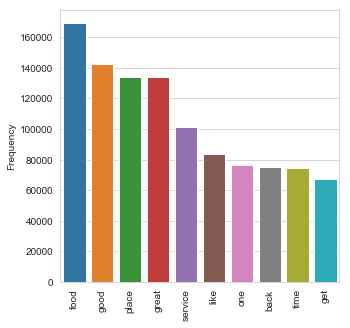

In [239]:
# the most frequently used words in the reviews
top_N = 100
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(10))
plt.xticks(rotation=90)
#ax.set_ylabel('')    
ax.set_xlabel('')

In [238]:
rslt [0:10]

,Word,Frequency
0,food,169057
1,good,142094
2,place,133784
3,great,133748
4,service,100998
5,like,83444
6,one,76224
7,back,75280
8,time,74737
9,get,67071


In [34]:
# word cloud
from wordcloud import WordCloud, STOPWORDS
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

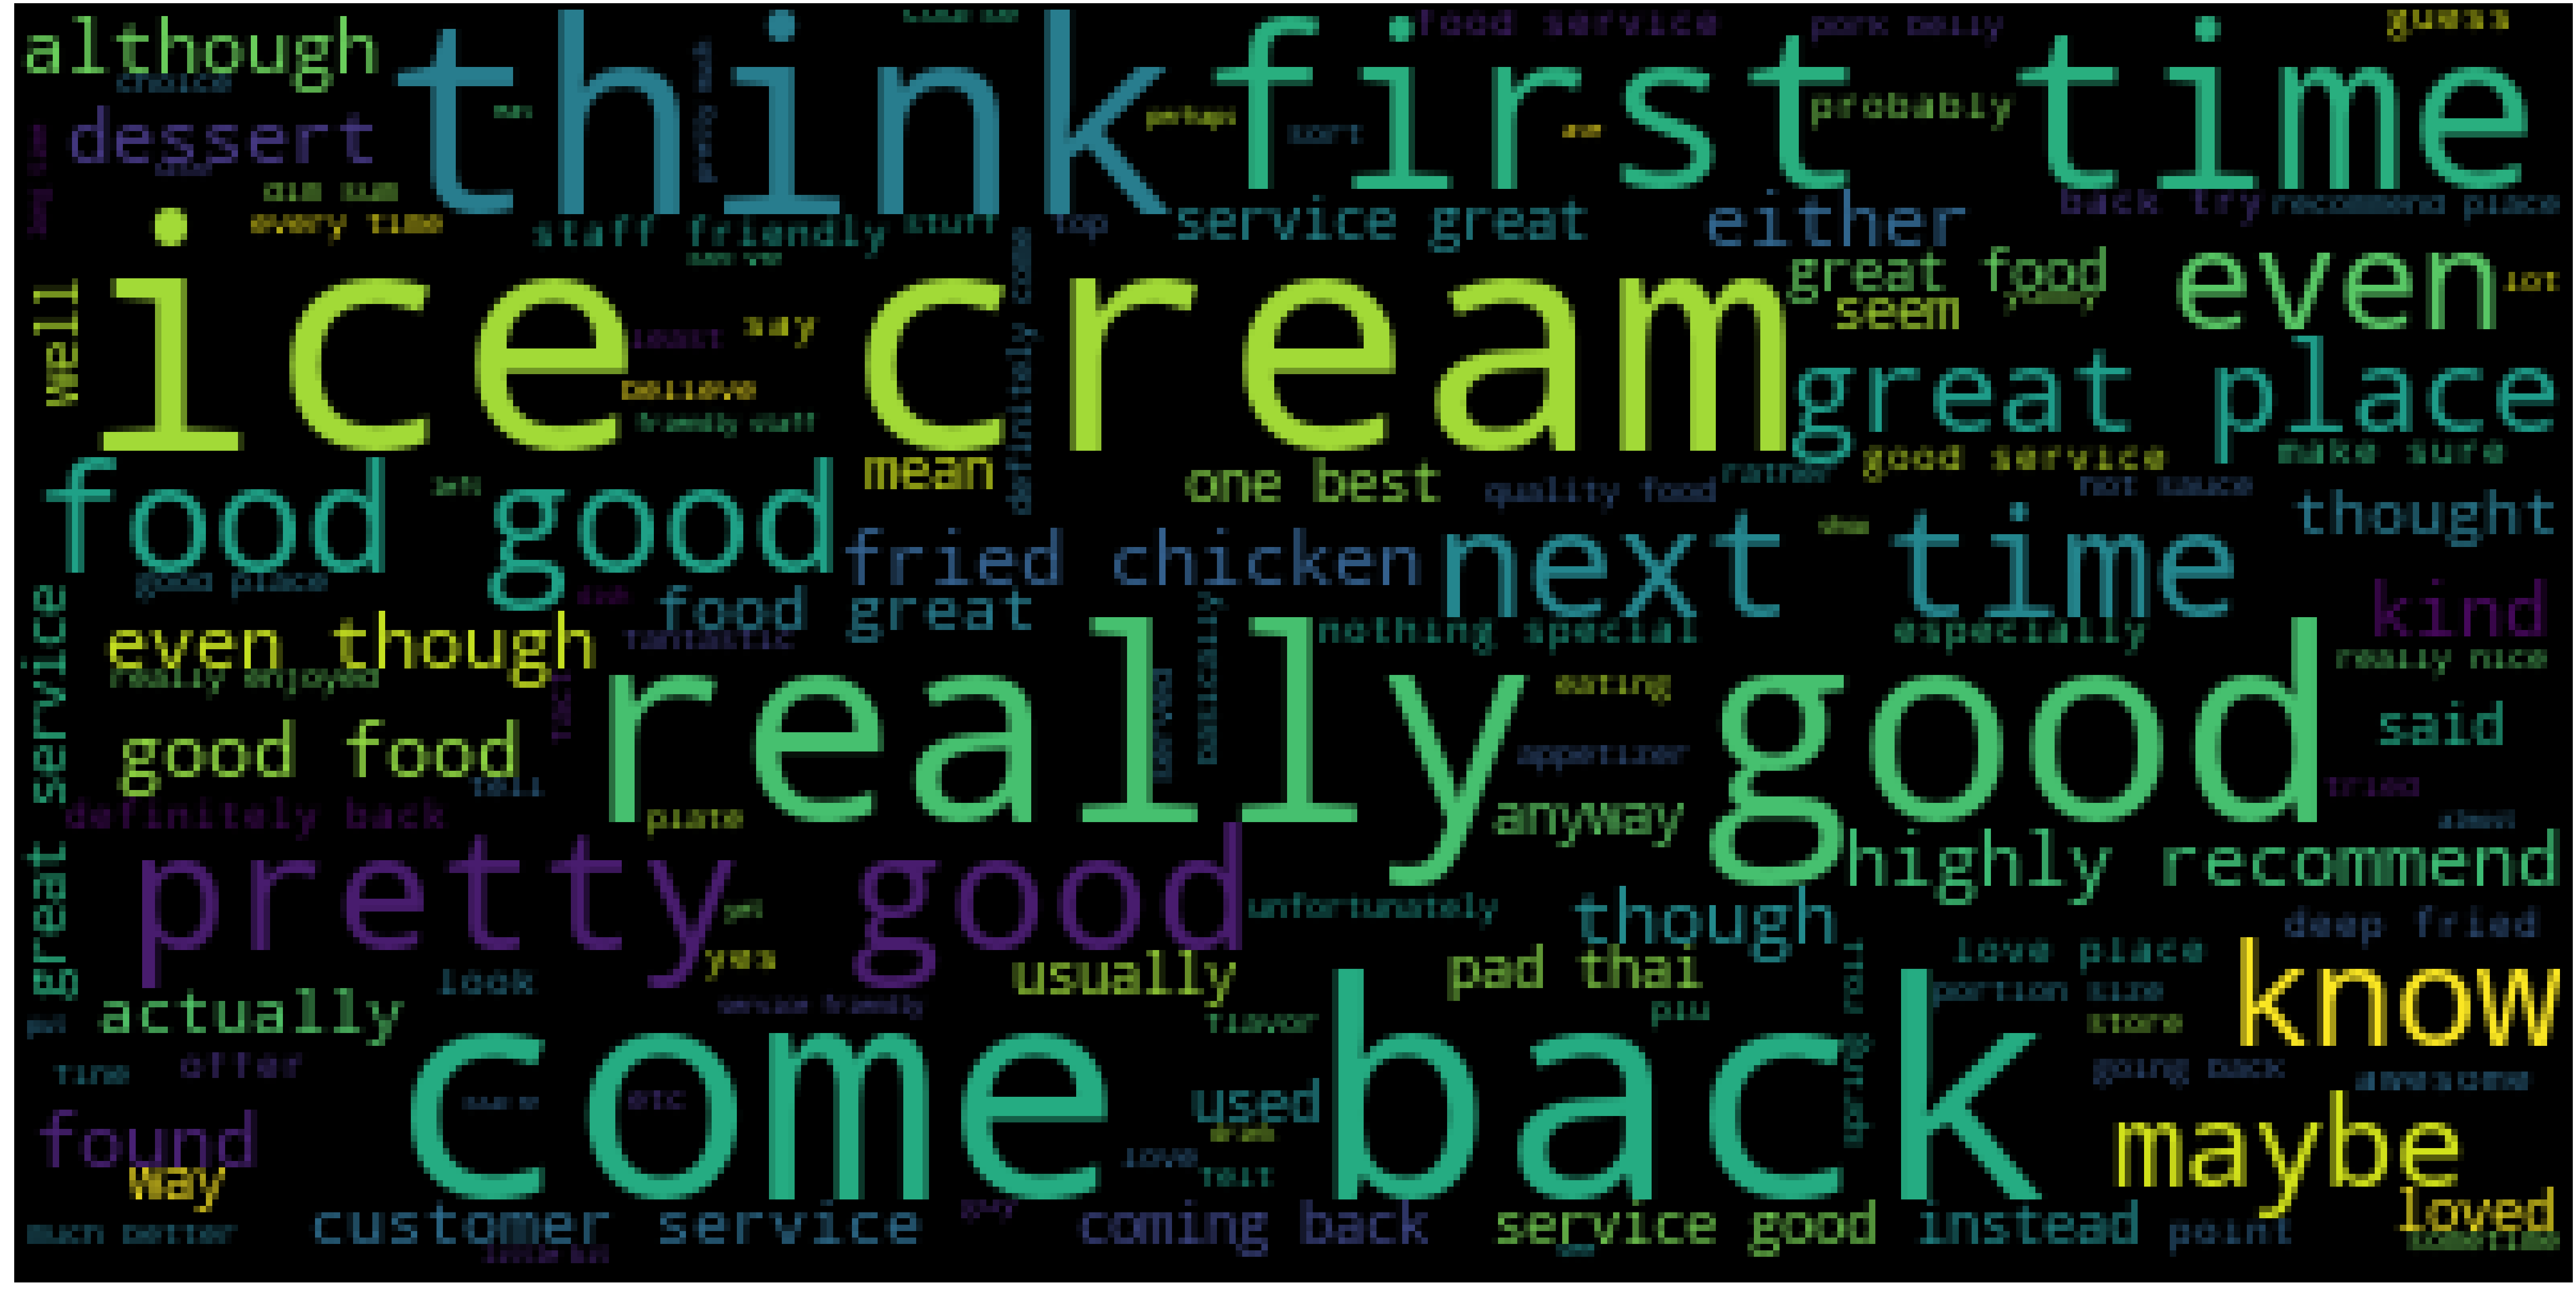

In [35]:
wc(cleaned_data_title,'white','Most Used Words')

#### Continue with popular words in positive and negative reviews

In [202]:
positive_reviews.head(2)

,Review,sentiment,polarity,Sentiment_Type
3,This is my first yelp. This restaurant was so...,0.583750,0.648333,1
5,After being a HUGE fan of the Mission I decide...,0.336606,0.582260,1
6,Was very excited for happy hour and heard grea...,0.226736,0.552083,1
7,The brussel sprout nachos are really as good a...,0.323472,0.525000,1
8,This place rules! Best tacos in town and not t...,0.490278,0.466667,1


In [204]:
negative_reviews.head(2) 

,Review,sentiment,polarity,Sentiment_Type
0,This place has gone down hill. Clearly they h...,-0.048611,0.350278,-1
16,The only thing I found interesting about the p...,-0.287500,0.690000,-1


In [ ]:
## how to create own stopwords?

 430985 was the older version of just fileter on Toronto
    # Esc + M + Entre --> markdown
    # Esc + Y + Entre --> back to code

In [82]:
#import textblob
#from textblob import TextBlob
#start_time = time.time()
#for index,row in df.iterrows():
#    analysis = TextBlob(df['text'][index])
#    sentiment, confidence = analysis.sentiment
#    review_df.at[index,'polarity'] = sentiment
#    df.at[index,'sentiment_confidence'] = confidence
    
#print("runtime: --- %s seconds ---" % (time.time() - start_time))    

### Load in pickled toronto sentiment

In [28]:
## load in pickled toronto sentiment
# load pickled file back in and check data validity 
filename = 'Sentiment_Toronto_Food'
infile = open(filename,'rb')
Sentiment_Toronto_Food= pickle.load(infile)
infile.close()
Sentiment_Toronto_Food.shape

(422050, 5)

In [31]:
# load in pickled Toronto food sentiment by business id
filename = 'Sentiment_Food_by_Bus'
infile = open(filename,'rb')
Sentiment_Food_by_Bus= pickle.load(infile)
infile.close()
print(Sentiment_Food_by_Bus.shape)
Sentiment_Food_by_Bus.head()

(10093, 4)


,business_id,sentiment_mean,polarity_mean,sentiment_type_sum
0,--DaPTJW3-tB1vP-PfdTEg,0.297714,0.562188,39
1,--SrzpvFLwP_YFwB_Cetow,0.183066,0.521290,36
2,-0DwB6Swi349EKfbBAOF7A,0.271510,0.481372,11
3,-0NhdsDJsdarxyDPR523ZQ,0.148577,0.545995,14
4,-0RRiWDtfnS16AKCtfvBZg,0.218121,0.444545,6
